# Dian 24 秋招 TEST3

## 定义MultiHeadAttention机制的类

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.init as init

class MultiHeadAttention(nn.Module):
    def __init__(self, feature_dims, head_nums):
        super().__init__()
        self.feature_dims = feature_dims
        self.head_nums = head_nums
        self.head_dims = feature_dims // head_nums
        
        # 设置初始化处理KQV矩阵的Linear层
        self.W_q = nn.Linear(self.head_dims, self.head_dims)
        self.W_k = nn.Linear(self.head_dims, self.head_dims)
        self.W_v = nn.Linear(self.head_dims, self.head_dims)
        
        # 输出的Linear层
        self.W_o = nn.Linear(self.head_dims * self.head_nums, feature_dims)
    
    def forward(self, queries, keys, values,valid_lens=None):
        # 提取批次数，以及KQV的样本数
        N = queries.shape[0]
        query_len = queries.shape[1]
        key_len = keys.shape[1]
        value_len = values.shape[1]

        # 根据‘头’的个数进行reshape
        queries = queries.reshape(N, query_len, self.head_nums, self.head_dims)
        keys = keys.reshape(N, key_len, self.head_nums, self.head_dims )
        values = values.reshape(N, value_len, self.head_nums, self.head_dims)

        #通过Linear层进行初始化
        queries = self.W_q(queries)  
        keys = self.W_k(keys)        
        values = self.W_v(values)    
        
        # 初步计算Attention的权重得分
        scores = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.head_nums, dim=0)
            scores = self.masked_fill(scores, valid_lens)#对初步计算得到的Attention进行MASK遮挡
            print('scores')
            print(scores)
        
        #下面对初步得到的权重矩阵进行处理
        # 将 scores Scaled
        scaled_scores = scores / (self.head_dims ** 0.5)
        
        # 应用Softmax函数对Attention权重矩阵进行归一化
        attention_weights = F.softmax(scaled_scores, dim=-1)
        
        # 将V矩阵与Softmax后的结果MatMul
        output = torch.einsum("nhql,nlhd->nqhd", [attention_weights, values])
        
        # 将output重塑
        output = output.reshape(N, query_len, self.head_nums * self.head_dims )
        
        # 最后通过W_o输出最终结果
        output = self.W_o(output)
        
        return output,attention_weights

    def masked_fill(self, scores, valid_lens):
        #进行mask遮挡操作
        mask = torch.arange(scores.size(-1), device=scores.device).expand(scores.size(0), scores.size(1), scores.size(2), -1) >= valid_lens.unsqueeze(1).unsqueeze(1)
        scores = scores.masked_fill(mask, float('-inf'))
        return scores

        
        

        
        








## 初始化权重

In [3]:
def initialize_weights(model):
    # 使用 Xavier 均匀分布初始化权重
    if isinstance(model, nn.Linear):
        init.xavier_uniform_(model.weight)
        if model.bias is not None:
            init.zeros_(model.bias)
    # 对模型的所有子模块应用初始化
    for m in model.children():
        initialize_weights(m)




## 初始化一个QKV矩阵

In [4]:
# 参数定义
feature_dims = 512
head_nums = 8
N = 1  # 批次大小
seq_len = 20  # 序列长度


# 随机生成Q、K、V矩阵
x = torch.normal(mean=0, std=1, size=(N, seq_len, feature_dims))



## 应用 MultiHeadAttention

In [5]:

# 创建多头注意力实例
multi_head_attn = MultiHeadAttention(feature_dims, head_nums)

initialize_weights(multi_head_attn)

# 打印模型结构
print(multi_head_attn)
# 查看每一层的参数
for name, param in multi_head_attn.named_parameters():
    print(f"Layer: {name}, Param: {param}")
# 计算输出
output, attention = multi_head_attn(x, x, x)

print(output)  # torch.Size([1, 10, 256])
print(attention)

attention = attention.squeeze(0)  # 假设N=1，去掉批次维度
avg_attention = attention.mean(dim=0)  # 取头部的平均


MultiHeadAttention(
  (W_q): Linear(in_features=64, out_features=64, bias=True)
  (W_k): Linear(in_features=64, out_features=64, bias=True)
  (W_v): Linear(in_features=64, out_features=64, bias=True)
  (W_o): Linear(in_features=512, out_features=512, bias=True)
)
Layer: W_q.weight, Param: Parameter containing:
tensor([[-0.1156,  0.1088, -0.1966,  ...,  0.0232, -0.0469,  0.0810],
        [-0.1246, -0.0225,  0.2031,  ...,  0.1109, -0.1412, -0.1310],
        [-0.0174,  0.0968, -0.0106,  ..., -0.1852, -0.0063, -0.0970],
        ...,
        [ 0.0258, -0.0674,  0.1759,  ..., -0.0024, -0.1222, -0.1650],
        [ 0.0739,  0.1687,  0.0175,  ...,  0.0144, -0.0067,  0.0046],
        [-0.0062,  0.0646, -0.2159,  ..., -0.1275,  0.1947, -0.1746]],
       requires_grad=True)
Layer: W_q.bias, Param: Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

## 可视化

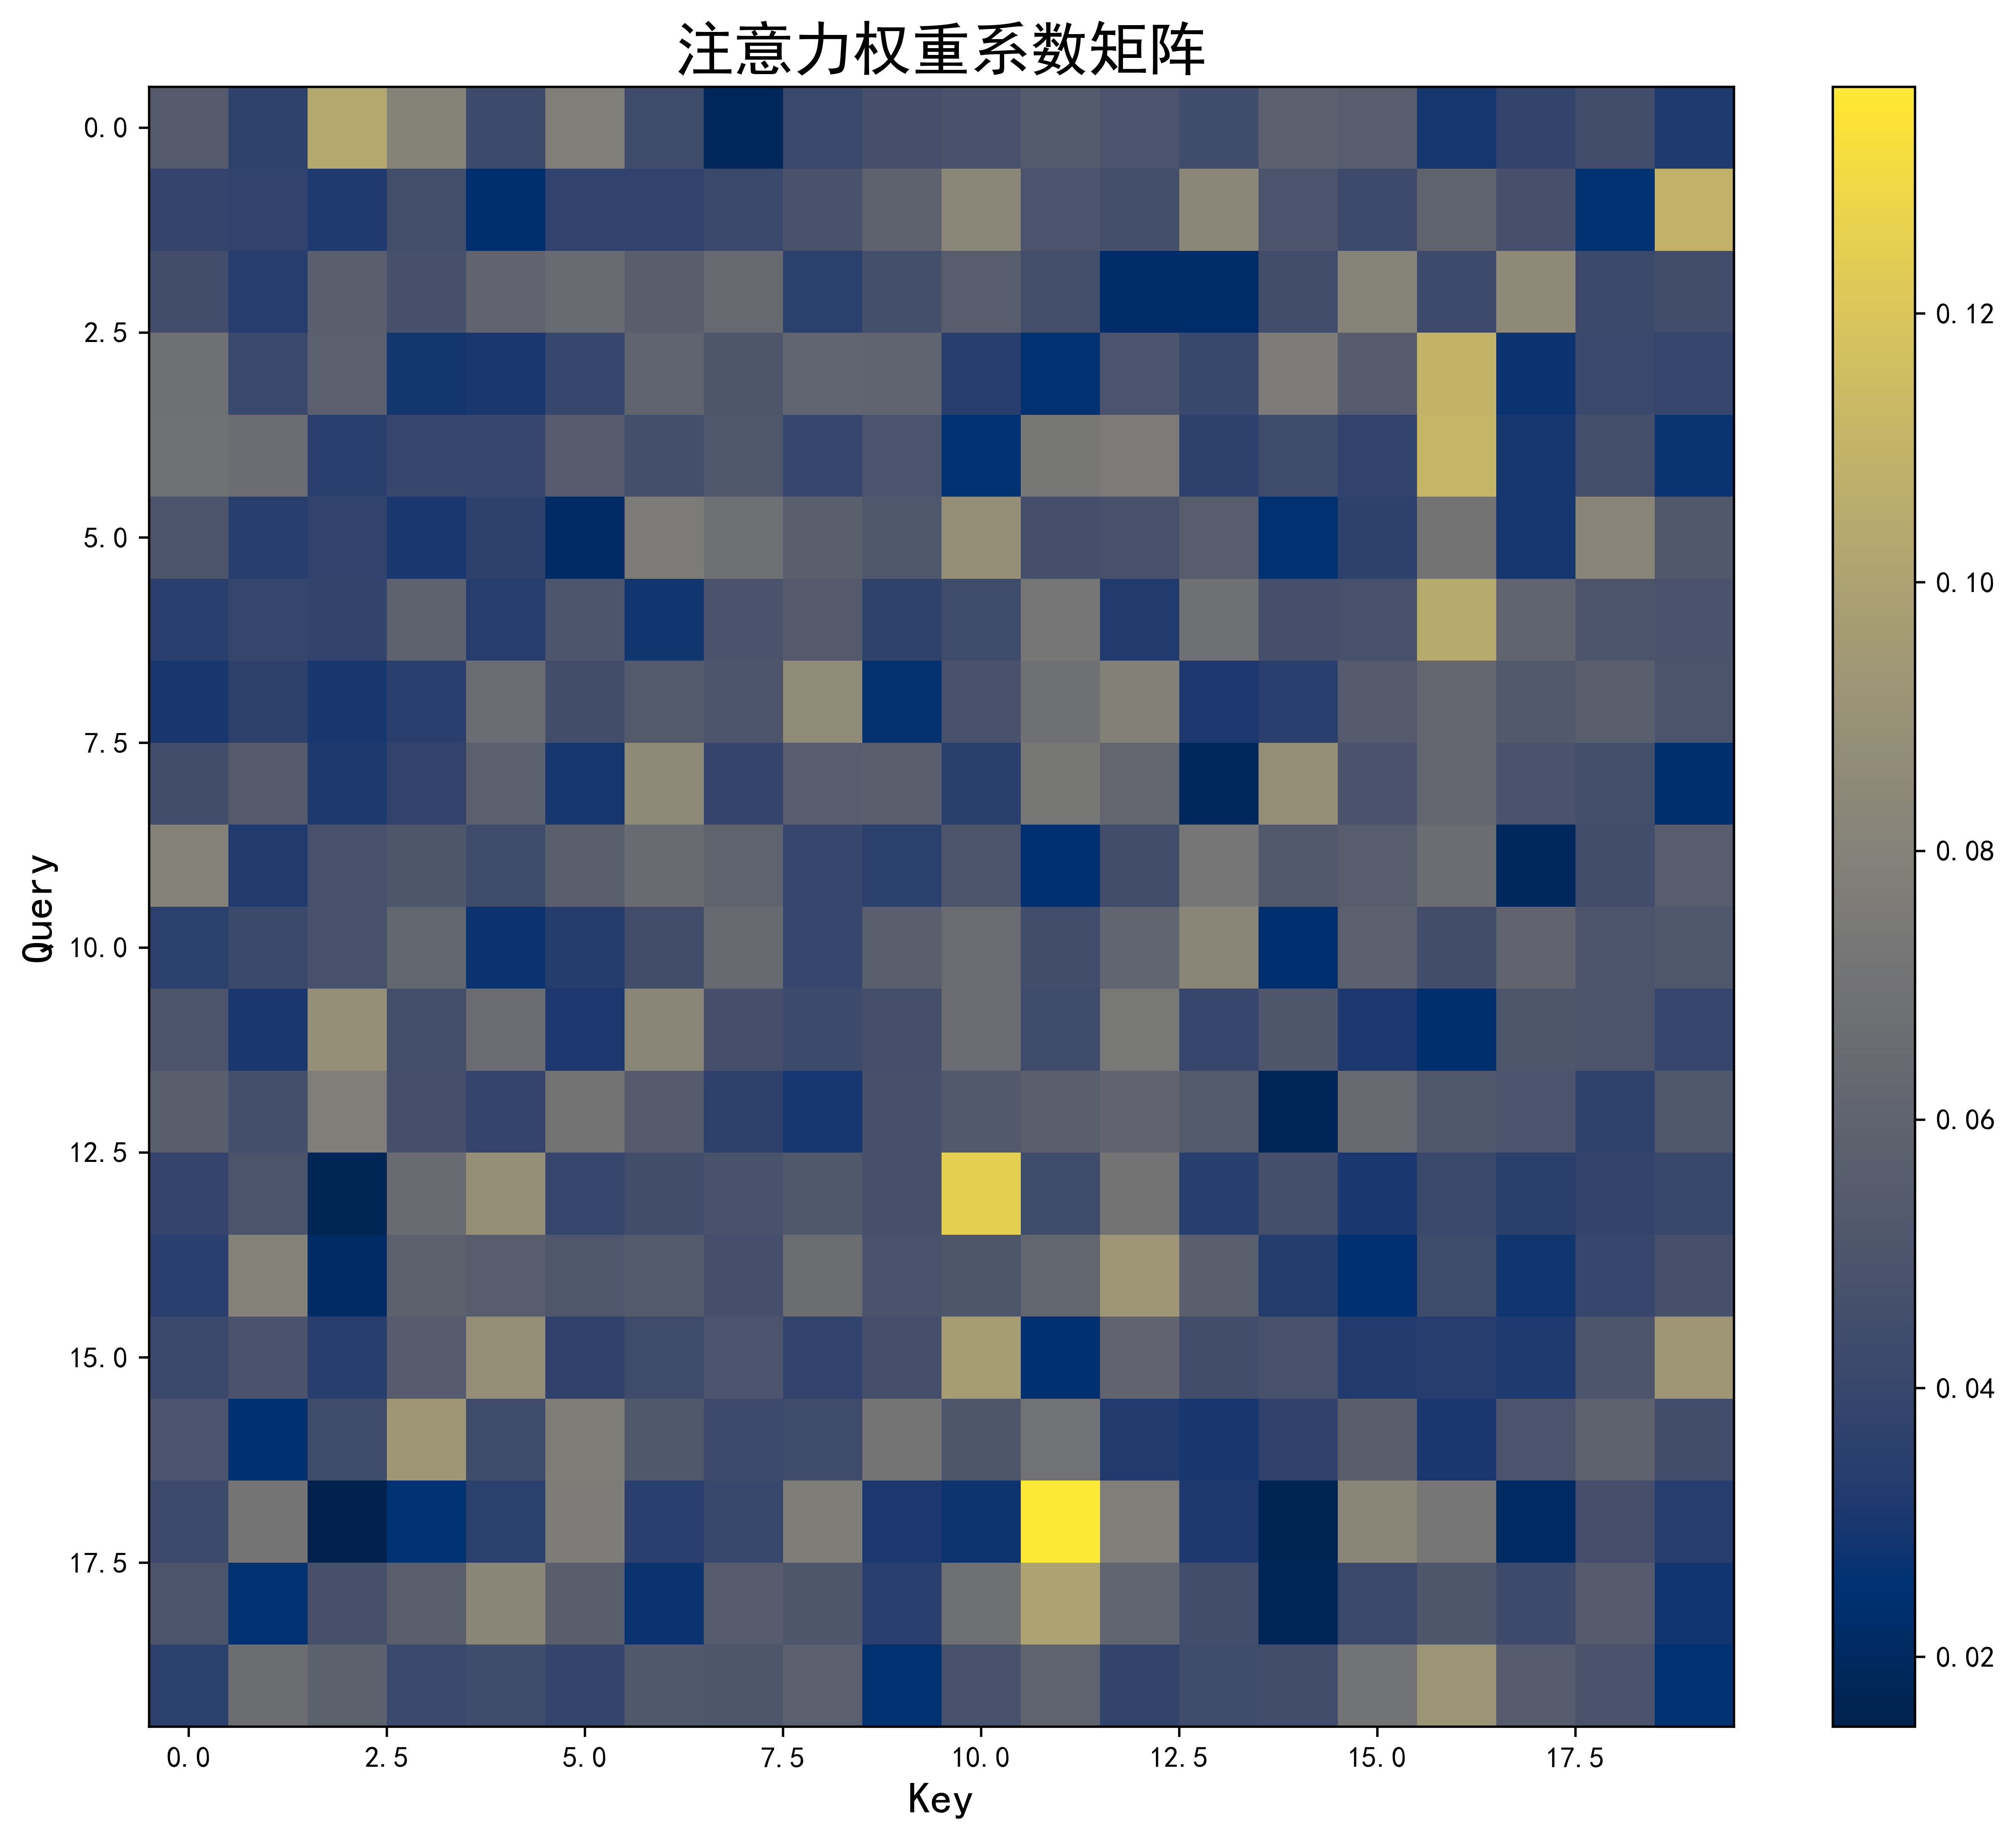

In [7]:

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 转换为 numpy 数组
avg_attention_np = avg_attention.cpu().detach().numpy()

# 绘制热力图
plt.figure(figsize=(12,10),dpi=500)

# 使用 'cividis' 颜色映射，添加轮廓线，设置插值方式为 'nearest'
plt.imshow(avg_attention_np, cmap='cividis', interpolation='nearest', aspect='auto')

plt.title('注意力权重系数矩阵',fontsize=20)
plt.xlabel('Key',fontsize=15)
plt.ylabel('Query',fontsize=15)
plt.colorbar()

plt.savefig('注意力权重系数矩阵.png')
# 显示图像
plt.show()
